# GADMA Tutorial

## Outline
1. Our Dataset
2. Overview of GADMA
3. Example Run of GADMA
4. Hands On

## Getting Help after Tutorial
- Contact: [enoskova.me](http://enoskova.me)
- Feel free to send me [email](mailto:ekaterina.e.noskova@gmail.com)
- [Getting help for GADMA](https://github.com/ctlab/GADMA#getting-help)

## 1.  Our Dataset

We have a dataset for clouded leopards (*Neofelis nebulosa*). We have data for 10 diploid individuals.

All the data is available in the `../2_data_preparation_tutorial/data` folder:

In [2]:
%%bash
ls ../2_data_preparation_tutorial/data

biallelic_snps.vcf
example_data.vcf
popmap.txt
pruned_variants.log
pruned_variants.nosex
pruned_variants.prune.in
pruned_variants.prune.out
pruned_variants.vcf


- File `data/example_data.vcf` is our VCF file for all 10 individuals (single chromosome of 10,000,000 bp):

In [3]:
%%bash
# First five lines
head -10 ../2_data_preparation_tutorial/data/example_data.vcf

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##source=tskit 0.5.7
##contig=<ID=CONTIG1,length=10000000>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	Leopard01	Leopard02	Leopard03	Leopard04	Leopard05	Leopard06	Leopard07	Leopard08	Leopard09	Leopard10
CONTIG1	32	0	G	A	.	PASS	.	GT	0|0	0|0	0|1	0|1	1|1	1|0	./.	0|1	1|1	1|1
CONTIG1	57	1	T	G	.	PASS	.	GT	0|0	0|0	0|1	0|1	1|1	./.	./.	0|1	1|1	1|1
CONTIG1	59	2	T	C	.	PASS	.	GT	1|1	1|1	1|0	1|0	0|0	0|1	0|1	1|0	0|0	0|0
CONTIG1	103	3	A	T	.	PASS	.	GT	0|0	0|0	0|0	1|0	0|0	0|0	0|0	0|0	0|0	0|0


- File `../2_data_preparation_tutorial/data/popmap.txt` provides population assignments per individual (all our individuals are from the same population that is marked as `NN`):

In [4]:
%%bash
cat ../2_data_preparation_tutorial/data/popmap.txt

Leopard01 NN
Leopard02 NN
Leopard03 NN
Leopard04 NN
Leopard05 NN
Leopard06 NN
Leopard07 NN
Leopard08 NN
Leopard09 NN
Leopard10 NN


- The length of the given sequence is equal to $10{,}000{,}000$ bp.

We will also use the following values associated with our species of interest [\[Bursell et al. 2022\]](https://doi.org/10.1016/j.isci.2022.105647):
- Generation time 7 years
- Mutation rate of $2.22 \times 10^{-9}$ per base pair per year = $1.554 \times 10^{-8}$ per base pair per **generation**
- Recombination rate of $1$ cM/Mb

## We have our SFS data

In [3]:
%%bash
ls ../3_easySFS_tutorial/outputs/easySFS_output/dadi/

NN-14.sfs
NN.sfs


## Picture of our SFS

In [4]:
%%bash
cp -r ../3_easySFS_tutorial/scripts ./

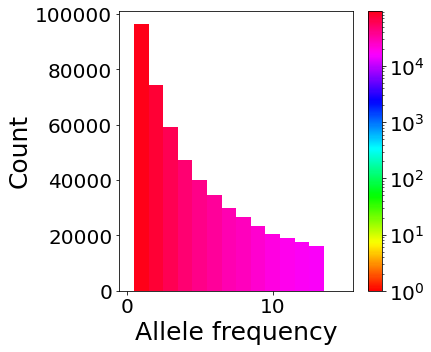

In [5]:
from scripts.draw_sfs import draw_1d_sfs
draw_1d_sfs("../3_easySFS_tutorial/outputs/easySFS_output/dadi/NN-14.sfs")

-----
## 2. Overview of GADMA

### What is [GADMA](https://github.com/ctlab/GADMA)?
- Tool for demographic inference from the genetic data.
- Provides demographic history that has highest value of likelihood with the data.
- Includes several likelihood components of existing tools under the common interface (`dadi`, `moments`, `momi2`, `momentsLD`)
- Has effective global optimization for parameter search.
- New model specification using *structure*.
- Repeats demographic inference and provides best result among several repeats (30 repeats is good, 100 is better).

Papers to cite: [\[Noskova et al. 2020\]](https://doi.org/10.1093/gigascience/giaa005), [\[Noskova et al. 2023\]](https://doi.org/10.1101/2022.06.14.496083) and other papers regarding used engines (see more [here](https://gadma.readthedocs.io/en/latest/citations.html)). 

### What is the difference between likelihood engines in GADMA?

GADMA has several engines to evaluate likelihood of the demographic history and data. More information about each engine could be found in the [documentation](https://gadma.readthedocs.io/en/latest/user_manual/set_engine.html).

<img src="pictures/Screenshot_engines.png" width="700" align="left"/>

### What is the model of the demographic history?

Classical tools for demographic inference require parameterized model of the demographic history. It should be specified using interface of the tool and could be error-prone. For example, let us consider the following model for the demographic history of two populations:
- Ancestral population had size equal to $N_{anc}$.
- Ancestral population experienced instanstenious growth up to ($nu_{1F}\cdot N_{anc}$) individuals and it has constant size for ($2\cdot T_p\cdot N_{anc}$) generations.
- Then second population diverged from ancestral population.
- Second population experienced exponential growth from ($nu_{2B}\cdot N_{anc}$) up to ($nu_{2F}\cdot N_{anc}$) individuals during ($2\cdot T\cdot N_{anc}$) generations after split.
- Size of the first population was equal to the size of ancestral population.
- There was migration between populations with rate equal to $m / (2\cdot N_{anc})$ migrants per generation.

This model has one parameter for $N_{anc}$ and additional 6 parameters. Example of the model specification for `dadi` using its Python API:

In [10]:
def prior_onegrow_mig(params, ns, pts):
    """
    Model with growth, split, bottleneck in pop2, exp recovery, migration

    params list is
    nu1F: The ancestral population size after growth. (Its initial size is
          defined to be 1.)
    nu2B: The bottleneck size for pop2
    nu2F: The final size for pop2
    m: The scaled migration rate
    Tp: The scaled time between ancestral population growth and the split.
    T: The time between the split and present

    ns = (n1,n2): Size of fs to generate.
    pts: Number of points to use in grid for evaluation.
    """
    nu1F, nu2B, nu2F, m, Tp, T = params
    n1,n2 = ns
    # Define the grid we'll use
    xx = yy = dadi.Numerics.default_grid(pts)

    # phi for the equilibrium ancestral population
    phi = dadi.PhiManip.phi_1D(xx)
    # Now do the population growth event.
    phi = dadi.Integration.one_pop(phi, xx, Tp, nu=nu1F)

    # The divergence
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    # We need to define a function to describe the non-constant population 2
    # size. lambda is a convenient way to do so.
    nu2_func = lambda t: nu2B*(nu2F/nu2B)**(t/T)
    phi = dadi.Integration.two_pops(phi, xx, T, nu1=nu1F, nu2=nu2_func, 
                                    m12=m, m21=m)

    # Finally, calculate the spectrum.
    sfs = dadi.Spectrum.from_phi(phi, (n1,n2), (xx,yy))
    return sfs

### Model specification using structure

GADMA requieres number of epochs in the demographic history. It has several additional handlers for flexibility:
- Enable/disable migrations
- Enable/disable selection
- Enable/disable dynamics of population size

More information [here](https://gadma.readthedocs.io/en/latest/user_manual/set_model/set_model_struct.html).

<img src="pictures/gadma.png" width="700" align="left"/>

### Dynamics of population size change

GADMA has flexible dynamics of population size change for model with structure.

Population dynamic can be:

- Constant (Sudden)
- Linear
- Exponential

<img src="pictures/sudden.png" width="150" align="left"/>
<img src="pictures/linear.png" width="150" align="left"/> 
<img src="pictures/exponential.png" width="150" align="left"/>

### Notes about structure

- Structure model could be used only for data of either 1, 2 or 3 populations. For 4 and 5 populations usual models could be used (custom models).
- Structure should not be very complex: \[3\] for one population, \[2, 1\] for two populations and \[2, 1, 1\] for three populations is enough.
- For three populations the most ancient population should be specified (in order to know the tree topology). It could be just sorted through all options.
- GADMA has a special inference scheme when the structure is increased: it starts from the simple initial structure and then use more complex structures until reachs the final one. Please, use this option as it provides better estimations.


--------
## 3. Example Run of GADMA

### Installation

[Documentation on installation](https://gadma.readthedocs.io/en/latest/user_manual/installation.html#installing-the-latest-release)

GADMA can be easily installed via `pip` or `conda`. Some of its engines (`momi2`) should be installed manually.



In [11]:
%%bash
#pip install gadma

### Run GADMA with the `--help` option

In [12]:
%%bash
gadma --help

GADMA version 2.0.3	by Ekaterina Noskova (ekaterina.e.noskova@gmail.com)
Usage: 
	gadma	-p/--params	<params_file>
		-e/--extra	<extra_params_file>


Instead/With -p/--params and -e/--extra option you can set:
	-o/--output	<output_dir>		output directory.
	-i/--input	<in.fs>/<in.txt>/	input data for demographic inference
			<in.vcf>,<popmap>	(AFS, dadi format or VCF).
	--resume	<resume_dir>		resume another launch from <resume_dir>.
	--only_models		flag to take models only from another
				launch (--resume option).

	-h/--help		show this help message and exit.
	-v/--version		show version and exit.
	--test			run test case.

In case of any questions or problems, please contact: ekaterina.e.noskova@gmail.com


### GADMA output

[More information about GADMA output in the documentation](https://gadma.readthedocs.io/en/latest/user_manual/output.html)

Before we run GADMA let us take a look at its output. GADMA was already run and it created an output directory.
- Our run was saved in `outputs/gadma_outputs/gadma_output_2epochs`:

In [6]:
%%bash
ls outputs/gadma_outputs/gadma_output_2epochs/

1
2
3
4
5
6
7
8
best_logLL_model_dadi_code.py
best_logLL_model_demes_code.py.yml
best_logLL_model_moments_code.py
best_logLL_model.png
extra_params_file
GADMA.log
params_file


- All command line output is saved in file `GADMA.log`:

In [7]:
%%bash
head -17 outputs/gadma_outputs/gadma_output_2epochs/GADMA.log

Data reading
Number of populations: 1
Projections: [14]
Population labels: ['NN']
Outgroup: True
--Successful data reading (0.00 s)--

--Successful arguments parsing--

Parameters of launch are saved in output directory: /home/enoskova/Workspace/GADMA_workshops/2025-10-GADMA_Worshop/tutorials/4_GADMA_tutorial/outputs/gadma_outputs/gadma_output_2epochs/params_file
All output is saved in output directory: /home/enoskova/Workspace/GADMA_workshops/2025-10-GADMA_Worshop/tutorials/4_GADMA_tutorial/outputs/gadma_outputs/gadma_output_2epochs/GADMA.log

--Start pipeline--
Run launch number 4
Run launch number 3
Run launch number 1


In [8]:
%%bash
tail -33 outputs/gadma_outputs/gadma_output_2epochs/GADMA.log


[000:02:05]
All best by log-likelihood models
Number	log-likelihood	Model	Units
Run 1	-98.04	 [Nanc = 338059] [ [ 31320.303(t1), [3640.886(nu11)], [Lin(dyn11)] ] ]	f	(theta =  210137.93)	physical, time in generations
Run 2	-98.45	 [Nanc = 338706] [ [ 36250.652(t1), [5755.691(nu11)], [Lin(dyn11)] ] ]	f	(theta =  210540.02)	physical, time in generations
Run 6	-99.35	 [Nanc = 337722] [ [ 12456.777(t1), [9191.624(nu11)], [Exp(dyn11)] ] ]	f	(theta =  209928.40)	physical, time in generations
Run 3	-101.48	 [Nanc = 338685] [ [ 18439.906(t1), [14277.145(nu11)], [Exp(dyn11)] ] ]	f	(theta =  210526.94)	physical, time in generations
Run 5	-102.57	 [Nanc = 338429] [ [ 6941.29(t1), [19573.813(nu11)], [Sud(dyn11)] ] ]	f	(theta =  210367.62)	physical, time in generations
Run 7	-103.07	 [Nanc = 339627] [ [ 42971.291(t1), [9129.879(nu11)], [Lin(dyn11)] ] ]	f	(theta =  211112.72)	physical, time in generations
Run 8	-103.56	 [Nanc = 339025] [ [ 20389.673(t1), [15928.828(nu11)], [Exp(dyn11)] ] ]	f	(theta

- Picture of the final history is saved in `outputs/gadma_outputs/gadma_output_2epochs/best_logLL_model.png`

<img src="outputs/gadma_outputs/gadma_output_2epochs/best_logLL_model.png" width="900" align="left"/>

- GADMA uses parameters file with specified options. Example of parameters file could be found [here](https://gadma.readthedocs.io/en/latest/user_manual/example_params_file.html).

In [16]:
%%bash
cat outputs/gadma_outputs/gadma_output_2epochs/params_file

#    This is a parameters file for GADMA software.

#    Lines that begin with # are ignored.
#    Comments at the end of a line are also ignored.
#    Each line contains: Parameter identifier : value.

#!!!     Indicates parameters that require special attention.

#!!!
#    Output directory for all GADMA outputs.
#    This should be set to a missing or empty directory.
#    If the process is resumed from another directory and the output 
#    directory is not specified, GADMA will append '_resumed' to the 
#    previous output directory.
Output directory: /Users/noskovae/Workspace/GADMA_workshops/2024-11-Demographic_Inference_Worshop/tutorials/3_GADMA_tutorial/outputs/gadma_outputs/gadma_output_2epochs

#!!!
#    Input data can be in the form of an SFS file (should end with .fs), 
#    a SNP file in Dadi format (should end with .txt), or a 
#    VCF file along with a popmap file (sample population map).
Input data: /Users/noskovae/Workspace/GADMA_workshops/2024-11-Demographic_Inferenc

#    25 years, then the bound will be 150000 / 25 = 6000.
#
#    Lower bound for split 1 (for 2 or 3 populations).
#    Default: None
Lower bound of first split: Null

#    Upper bound for split 1 (in case of 2 or 3 populations).
#    Default: None
Upper bound of first split: Null

#    Lower bound for split 2 (in case of 3 populations).
#    Default: None
Lower bound of second split: Null

#    Upper bound for split 2 (in case of 3 populations).
#    Default: None
Upper bound of second split: Null

#!!!
#    Local optimization.
#
#    Choice of local optimization that is launched after 
#    each genetic algorithm.
#    Choices:
#
#    *    optimize (BFGS method)
#    
#    *    optimize_log (BFGS method)
#    
#    *    optimize_powell (Powell’s conjugate direction method)
#    (Note: implemented in moments; one needs to have moments 
#    installed.)
#
#    (If optimizations often hit the parameter bounds, 
#    try using these methods:)
#    *    optimize_lbfgsb
#    *    optimize_

- Each repeat of GADMA run is saved in its own folder:

In [17]:
%%bash
ls outputs/gadma_outputs/gadma_output_2epochs/1

current_best_logLL_model_dadi_code.py
current_best_logLL_model_demes_code.py.yml
current_best_logLL_model_moments_code.py
eval_file
final_best_logLL_model_dadi_code.py
final_best_logLL_model_demes_code.py.yml
final_best_logLL_model_moments_code.py
final_best_logLL_model.png
GADMA_GA.log
save_file_1
save_file_2


### Run GADMA for one-epoch demographic history inference

Let us run GADMA for our data. We need to specify params_file for GADMA with options. We will use moments in our example, but you can choose either `dadi` or `momi2` as well (they are also SFS-based engines).

In [1]:
%%bash
cat gadma_params_files/gadma_params_file_1epoch

Input data: ../3_easySFS_tutorial/outputs/easySFS_output/dadi/NN-14.sfs
Output directory: outputs/gadma_outputs/gadma_output_1epoch

Mutation rate: 1.554e-8
Sequence length: 10000000

Engine: moments

# Those are default options:
# Initial structure: 1
# Final structure: 1

Number of repeats: 8
Number of processes: 4


In [ ]:
%%bash
rm -rf outputs/gadma_outputs/gadma_output_1epoch
gadma -p gadma_params_files/gadma_params_file_1epoch

### Run GADMA for two-epoch demographic history inference

In [6]:
%%bash
cat gadma_params_files/gadma_params_file_2epochs

Input data: ../3_easySFS_tutorial/outputs/easySFS_output/dadi/NN-14.sfs
Output directory: outputs/gadma_outputs/gadma_output_2epochs

Mutation rate: 1.554e-8
Sequence length: 10000000

Engine: moments

Initial structure: 1
Final structure: 2

Number of repeats: 8
Number of processes: 4

# For demonstration purpose
min_N: 0.05


In [1]:
%%bash
rm -rf outputs/gadma_outputs/gadma_output_2epochs
gadma -p gadma_params_files/gadma_params_file_2epochs

Data reading
Number of populations: 1
Projections: [14]
Population labels: ['NN']
Outgroup: True
--Successful data reading (0.00 s)--

--Successful arguments parsing--



Parameters of launch are saved in output directory: /home/enoskova/Workspace/GADMA_workshops/2025-10-GADMA_Worshop/tutorials/4_GADMA_tutorial/outputs/gadma_outputs/gadma_output_2epochs/params_file
All output is saved in output directory: /home/enoskova/Workspace/GADMA_workshops/2025-10-GADMA_Worshop/tutorials/4_GADMA_tutorial/outputs/gadma_outputs/gadma_output_2epochs/GADMA.log

--Start pipeline--
Run launch number 4
Run launch number 3
Run launch number 2
Run launch number 1


Finish genetic algorithm number 3
Run launch number 5


Finish genetic algorithm number 4
Run launch number 6



[000:01:00]
All best by log-likelihood models
Number	log-likelihood	Model	Units
Run 2	-98.45	 [Nanc = 338706] [ [ 36250.652(t1), [5755.691(nu11)], [Lin(dyn11)] ] ]	(theta =  210540.02)	physical, time in generations
Run 1	-98.85	 [Nanc = 337403] [ [ 31238.967(t1), [3736.726(nu11)], [Lin(dyn11)] ] ]	m	(theta =  209730.04)	physical, time in generations
Run 3	-101.48	 [Nanc = 338685] [ [ 18439.906(t1), [14277.145(nu11)], [Exp(dyn11)] ] ]	f	(theta =  210526.94)	physical, time in generations
Run 5	-102.57	 [Nanc = 338503] [ [ 6949.538(t1), [19578.135(nu11)], [Sud(dyn11)] ] ]	m	(theta =  210414.07)	physical, time in generations
Run 6	-110.96	 [Nanc = 340089] [ [ 11878.566(t1), [8378.156(nu11)], [Exp(dyn11)] ] ]	c	(theta =  211399.33)	physical, time in generations
Run 4	-130.21	 [Nanc = 340803] [ [ 32101.226(t1), [25655.739(nu11)], [Exp(dyn11)] ] ]	f	(theta =  211843.19)	physical, time in generations

You can find the picture and the Python code of the best model in the output directory.

Fin

Finish genetic algorithm number 5
Run launch number 8


Finish genetic algorithm number 6
Finish genetic algorithm number 1
Finish genetic algorithm number 7

[000:02:00]
All best by log-likelihood models
Number	log-likelihood	Model	Units
Run 1	-98.04	 [Nanc = 338059] [ [ 31320.303(t1), [3640.886(nu11)], [Lin(dyn11)] ] ]	f	(theta =  210137.93)	physical, time in generations
Run 2	-98.45	 [Nanc = 338706] [ [ 36250.652(t1), [5755.691(nu11)], [Lin(dyn11)] ] ]	f	(theta =  210540.02)	physical, time in generations
Run 6	-99.35	 [Nanc = 337722] [ [ 12456.777(t1), [9191.624(nu11)], [Exp(dyn11)] ] ]	f	(theta =  209928.40)	physical, time in generations
Run 3	-101.48	 [Nanc = 338685] [ [ 18439.906(t1), [14277.145(nu11)], [Exp(dyn11)] ] ]	f	(theta =  210526.94)	physical, time in generations
Run 5	-102.57	 [Nanc = 338429] [ [ 6941.29(t1), [19573.813(nu11)], [Sud(dyn11)] ] ]	f	(theta =  210367.62)	physical, time in generations
Run 7	-103.07	 [Nanc = 339627] [ [ 42971.291(t1), [9129.879(nu11)], [Lin(dyn11)] ] ]	f	(theta =  211112.72)	physical, time in gene

### Run GADMA for two-epoch demographic history inference with wide bounds

Sometimes GADMA prints:
```text
INFO: Some parameters of the best model hit their bounds: nu11 hit lower bounds
```

The bounds for the parameters are the following (they are located in the `extra_params_file`, more information is [here](https://gadma.readthedocs.io/en/latest/user_manual/extra_params_file.html)):
- Minimum population size `min_N` = $0.01 (\cdot N_{anc})$
- Maximum population size `max_N` = $100 (\cdot N_{anc})$
- Minimum epoch time `min_T` = ~$0$
- Maximum epoch time `max_T` = $5 (\cdot 2 \cdot N_{anc})$
- Minimum migration rate `min_m` = $0$
- Maximum migration rate `max_m` = $10 (/ (2\cdot N_{anc}))$

All values for `dadi` and `moments` are in genetic units. We should check the parameters in output file with code. We are looking for `p0`:

In [9]:
%%bash
head -20 outputs/gadma_outputs/gadma_output_2epochs/best_logLL_model_moments_code.py

import moments
import numpy as np

def model_func(params, ns):
	t1, nu11 = params
	_Nanc_size = 1.0  # This value can be used in splits with fractions
	sts = moments.LinearSystem_1D.steady_state_1D(np.sum(ns))
	fs = moments.Spectrum(sts)
	nu1_func = lambda t: _Nanc_size + (nu11 - _Nanc_size) * (t / t1)
	fs.integrate(tf=t1, Npop=lambda t: [nu1_func(t)], dt_fac=0.01)
	return fs

data = moments.Spectrum.from_file('/home/enoskova/Workspace/GADMA_workshops/2025-10-GADMA_Worshop/tutorials/3_easySFS_tutorial/outputs/easySFS_output/dadi/NN-14.sfs')
ns = data.sample_sizes

p0 = [0.046323623766058315, 0.010769949941454323]
lower_bound = [1e-15, 0.01]
upper_bound = [5.0, 100.0]
model = model_func(p0, ns)
ll_model = moments.Inference.ll_multinom(model, data)


In [ ]:
%%bash
cat gadma_params_files/gadma_params_file_2epochs_wide_bounds

In [ ]:
%%bash
rm -rf outputs/gadma_outputs/gadma_output_2epochs_wide_bounds
gadma -p gadma_params_files/gadma_params_file_2epochs_wide_bounds

### Run GADMA for three-epoch demographic history inference using previous runs

In [ ]:
%%bash
cat gadma_params_files/gadma_resume_3epochs

In [ ]:
%%bash
gadma --resume outputs/gadma_outputs/gadma_output_2epochs_wide_bounds \
-p gadma_params_files/gadma_resume_3epochs \
-o outputs/gadma_outputs/gadma_output_3epochs

### Reconstruct the Likelihood

We can obtain the likelihood of the best result by running generated code from GADMA:

In [ ]:
%%bash
python outputs/gadma_outputs/gadma_output_3epochs/best_logLL_model_moments_code.py

---
## 4. Hands On!

Repeat this tutorial on your computer and obtain the results. Please send your results to us [here](https://forms.gle/cs6xY7y9pUA3AaBH7).

You can change run options if you like:
* Use different engine: e.g. `dadi`
* Use time for one generation of 7 years
* Any other option